# ch04.03 Generative Model - DCGAN

* 날짜:
* 이름:

## 학습내용
    - 딥러닝 생성모델에 대해 이해한다.
    - Deep Convolutional Generative Adversarial Networks 를 구현한다.

> https://arxiv.org/pdf/1406.2661.pdf



## 실습
---

### | **모델 구현**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-02.PNG?raw=true' width=800>
</p>

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils

def build_gene(z_dim=32, img_shape=(28, 28, 1)):
  w, h, c = img_shape
  z = layers.Input(shape=[z_dim])
  y = layers.Dense( int(w/4) * int(h/4) * 128)(z)
  y = layers.Reshape([int(w/4),int(h/4), 128])(y)
  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2, activation='relu')(y) 
  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(c, kernel_size=5, padding='same', strides=2, activation='sigmoid')(y)
  return models.Model(z, y, name='Generator')

def build_disc(img_shape=(28,28,1)):
  x = layers.Input(shape=img_shape)
  y = layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(x)
  y = layers.Dropout(.5)(y)
  y = layers.Conv2D(128, kernel_size=5, strides=2, padding='same', activation='relu')(y)
  y = layers.Dropout(.5)(y)
  y = layers.Flatten()(y)
  y = layers.Dense(1, activation='sigmoid')(y)
  return models.Model(x,y, name='Discriminator')

g= build_gene(128, (32,32,3))
g.summary()

d = build_disc((32,32,3))
d.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_10 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_5 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 64)       204864    
 Transpose)                                                      
                                                                 
 batch_normalization_11 (Bat  (None, 16, 16, 64)       25

(1, 128) (1, 32, 32, 3)


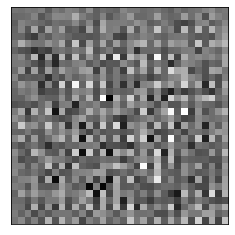

[[0.49561834]]


In [9]:
import matplotlib.pyplot as plt
z = tf.random.normal([1,128])
fake_img = g.predict(z)
print(z.shape, fake_img.shape)
plt.imshow(fake_img[0,:,:,0], cmap='gray');plt.xticks([]);plt.yticks([])
plt.show()
logit = d.predict(fake_img)
print(logit)

# 데이터

In [18]:
batch_size=32

#def get_mnist():
(x_train, _),(_,_) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.
x_train = np.expand_dims(x_train, 3)
ds = tf.data.Dataset.from_tensor_slices(x_train)
ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
x_train.shape
ds

<PrefetchDataset element_spec=TensorSpec(shape=(32, 28, 28, 1), dtype=tf.float64, name=None)>

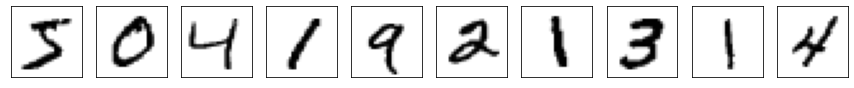

In [26]:
def display_sample_img(samples, cmap='gray_r'):
  plt.figure(figsize=(15,3))
  for i,sample in enumerate(samples):
    #sample = ( sample  + 1. ) / 2.
    #sample = np.clip(sample, 0, 1)
    if i==10:break
    plt.subplot(1,10,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap=cmap)
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()

display_sample_img(x_train[:10])

### **| 학습**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-01.PNG?raw=true' width=600>
</p>

In [15]:
import numpy as np
import matplotlib.pyplot as plt


In [25]:
ones = tf.constant([1.], shape=[batch_size, 1])
zeros = tf.constant([0.], shape=[batch_size, 1])
ones.shape, zeros.shape

(TensorShape([32, 1]), TensorShape([32, 1]))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 100)]             0         
                                                                 
 Generator (Functional)      (None, 28, 28, 1)         840705    
                                                                 
 Discriminator (Functional)  (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


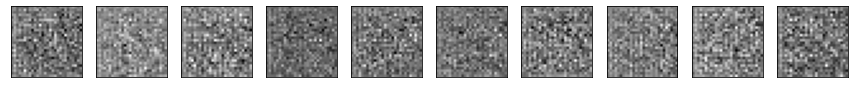

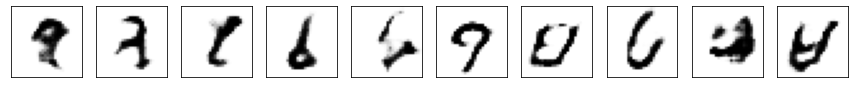

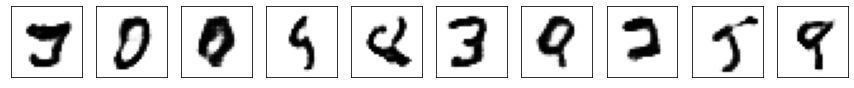

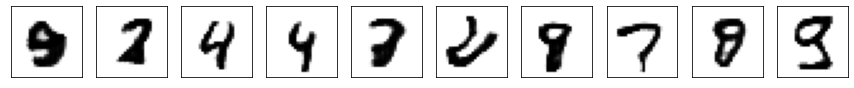

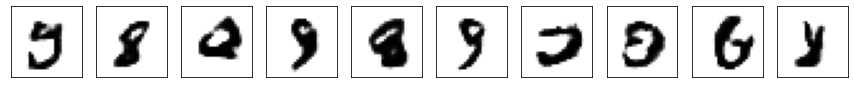

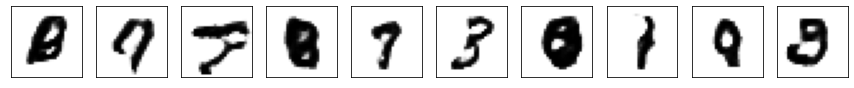

In [28]:
noise_dims = 100
epochs = 5
img_shape= (28,28,1)

G = build_gene(noise_dims, img_shape)
D = build_disc(img_shape)

D.compile(loss='binary_crossentropy', optimizer='adam')
D.trainable=False
input_noises=layers.Input(shape=noise_dims)
fake_img = G(input_noises)
logit = D(fake_img)
GAN = models.Model(input_noises, logit)
GAN.compile(loss='binary_crossentropy', optimizer='adam')
GAN.summary()

for epoch in range(epochs+1):
  if epoch!=0:
    for real_imgs in ds: #20000개중 32개씩
      noises = tf.random.normal(shape=[batch_size, noise_dims]) #p 가우시안 확률 분포
      fake_imgs = G.predict_on_batch(noises)
      #print(noises.shape)#z
      #print(real_imgs.shape)#x

      # phase 1. 판별자 훈련
      d.trainable = True
      D_loss_real = D.train_on_batch(real_imgs, ones)
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)
      D_loss = (0.5*D_loss_real + 0.5*D_loss_fake) / float(batch_size)
      
      # phase 2. 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape=[batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones)

  noises = tf.random.normal(shape=[batch_size, noise_dims])
  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])


In [30]:
batch_size=32

#def get_mnist():
(x_train, _),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.
x_train = np.expand_dims(x_train, 3)
ds = tf.data.Dataset.from_tensor_slices(x_train)
ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
x_train.shape

(60000, 28, 28, 1)

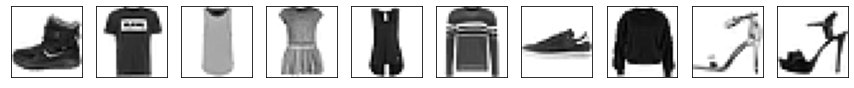

In [31]:
display_sample_img(x_train[:10])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 100)]             0         
                                                                 
 Generator (Functional)      (None, 28, 28, 1)         840705    
                                                                 
 Discriminator (Functional)  (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


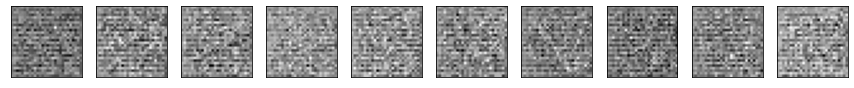

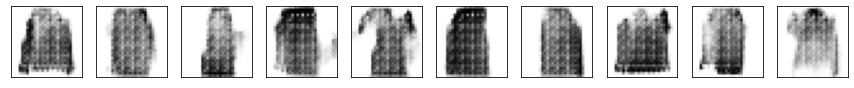

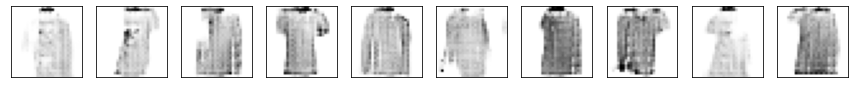

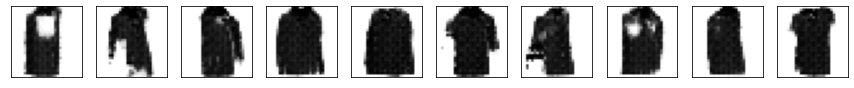

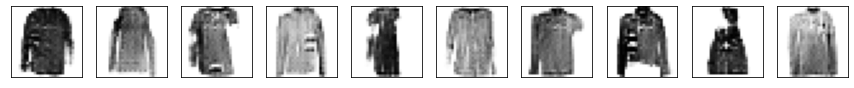

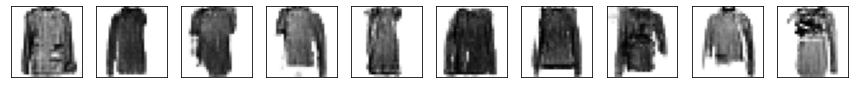

In [32]:
noise_dims = 100
epochs = 5
img_shape= (28,28,1)

G = build_gene(noise_dims, img_shape)
D = build_disc(img_shape)

D.compile(loss='binary_crossentropy', optimizer='adam')
D.trainable=False
input_noises=layers.Input(shape=noise_dims)
fake_img = G(input_noises)
logit = D(fake_img)
GAN = models.Model(input_noises, logit)
GAN.compile(loss='binary_crossentropy', optimizer='adam')
GAN.summary()

for epoch in range(epochs+1):
  if epoch!=0:
    for real_imgs in ds: #20000개중 32개씩
      noises = tf.random.normal(shape=[batch_size, noise_dims]) #p 가우시안 확률 분포
      fake_imgs = G.predict_on_batch(noises)
      #print(noises.shape)#z
      #print(real_imgs.shape)#x

      # phase 1. 판별자 훈련
      d.trainable = True
      D_loss_real = D.train_on_batch(real_imgs, ones)
      D_loss_fake = D.train_on_batch(fake_imgs, zeros)
      D_loss = (0.5*D_loss_real + 0.5*D_loss_fake) / float(batch_size)
      
      # phase 2. 생성자 훈련
      D.trainable = False
      noises = tf.random.normal(shape=[batch_size, noise_dims])
      G_loss = GAN.train_on_batch(noises, ones)

  noises = tf.random.normal(shape=[batch_size, noise_dims])
  fake_imgs = G.predict(noises)
  display_sample_img(fake_imgs[:10])
